In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import gcm_filters

In [24]:
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_obs_ssh_my_allsat_l4_duacs_ptdeg_P1D_1993_2020.nc'
ds = xr.open_dataset(av_path)
av_time_o = range(len(ds.time))
avsla = ds.sla[av_time_o,:,:]
# avsla_mean = avsla.sel(time=slice("1993-01-01", "2017-12-31")).mean(dim='time') # mean over range we have ECCO data 
# avsla = avsla - avsla_mean

/Users/jakesteinberg/anaconda3/envs/gcm_filt/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jakesteinberg/anaconda3/envs/gcm_filt/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


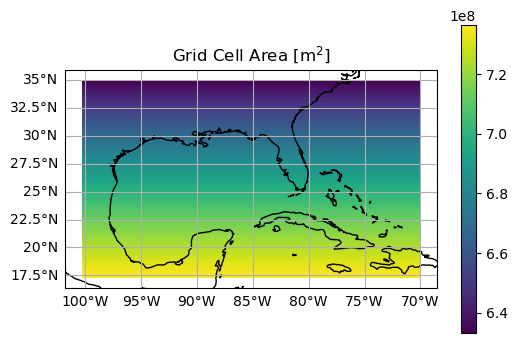

In [25]:
# -- compute cell area -- 
# -- for each lat/lon grid box gcm-filters needs area in same format as du,dv
dy0 = 1852*60*np.abs(ds['latitude'][2].data - ds['latitude'][1].data)
# ** note: dy0 is a constant over the globe ** 
dx0 = 1852*60*np.cos(np.deg2rad(ds['latitude'].data))*(ds['longitude'][2].data - ds['longitude'][1].data) 
area = dy0*np.tile(dx0, (len(ds['longitude'].data),1))
area = np.transpose(area)
dA = xr.DataArray(
    data=area,
    dims=["latitude", "longitude"],
    coords=dict(
    longitude=(["longitude"], ds['longitude'].data), latitude=(["latitude"], ds['latitude'].data),),
)
area_cmap = 'viridis'       # colormap 
f,ax = plt.subplots(1,1,figsize=(6,4),subplot_kw={'projection':ccrs.PlateCarree()})
dA.plot(ax=ax, cmap=area_cmap)
ax.set_title('Grid Cell Area [m$^2$]')
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.show()

In [26]:
# -- wet mask -- 
# -- land = 1, water = 0 -- 
wetMask = xr.where(np.isnan(avsla[0]), 0, 1)

In [27]:
# -- call gcm-filters and select desired grid type -- 
gcm_filters.required_grid_vars(gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED)

['area', 'wet_mask']

In [35]:
# -- choose a filtering scale -- 
filter_scale = 8
dx_min = 1
# -- initialze filter object for two filter types -- 
specs = {
    'filter_scale': filter_scale,
    'dx_min': dx_min,
    'grid_type': gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
    'grid_vars': {'area': dA, 'wet_mask': wetMask}
}
# GAUSSIAN 
filter_simple_fixed_factor_G = gcm_filters.Filter(filter_shape=gcm_filters.FilterShape.GAUSSIAN, **specs)

In [36]:
# -- filter velocities, filter KE, and define EKE (for both Gaussian and Taper kernels) -- 
sla_filtered_simple_fixed_factor = filter_simple_fixed_factor_G.apply(avsla, dims=['latitude', 'longitude'])

In [39]:
time_i = 100
avsla_0 = avsla[time_i].squeeze()
avsla_1deg = sla_filtered_simple_fixed_factor[time_i].squeeze()

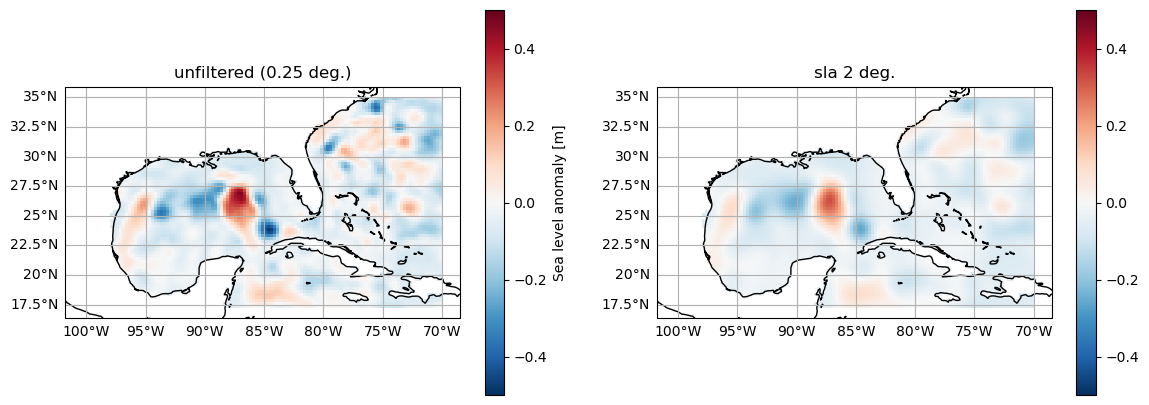

In [40]:
ke_lims = [-.5, .5]  # colormap limits (m^2 s^(-1))
ke_cmap = 'RdBu_r'       # colormap 

# -- PLOT --  
f,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5),subplot_kw={'projection':ccrs.PlateCarree()})
avsla_0.plot(ax=ax1, cmap=ke_cmap, vmin=ke_lims[0], vmax=ke_lims[1])
ax1.set(title='unfiltered (0.25 deg.)')

avsla_1deg.plot(ax=ax2, cmap=ke_cmap, vmin=ke_lims[0], vmax=ke_lims[1])
ax2.set(title='sla 2 deg.')

gax = [ax1, ax2]
for i in [0,1]:
    gax[i].coastlines()
    # gax[i].set_extent([300, 330, 32.5, 52.5], crs=ccrs.PlateCarree())
    gl = gax[i].gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
plt.show()

In [41]:
filename = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/sla_filtered2deg_1993_2020.nc'
sla_filtered_simple_fixed_factor.to_netcdf(path=filename)

In [33]:
sla_filtered_simple_fixed_factor

<xarray.DataArray (time: 10227, latitude: 71, longitude: 121)>
array([[[            nan,             nan,             nan, ...,
         -4.82101271e-04,  5.48667909e-03,  1.23611804e-02],
        [            nan,             nan,             nan, ...,
         -2.04275203e-02, -1.62752328e-02, -1.04328063e-02],
        [            nan,             nan,             nan, ...,
         -2.20630029e-02, -2.13719835e-02, -1.75123802e-02],
        ...,
        [            nan,             nan,             nan, ...,
          9.63007565e-02,  9.20438644e-02,  8.94603061e-02],
        [            nan,             nan,             nan, ...,
          8.41688945e-02,  8.71054912e-02,  8.99794439e-02],
        [            nan,             nan,             nan, ...,
          4.86289028e-02,  5.54552457e-02,  6.24474440e-02]],

       [[            nan,             nan,             nan, ...,
         -3.72259949e-05,  6.82923185e-03,  1.33824290e-02],
        [            nan,             nan,             nan, ...,
         -1.82370659e-02, -1.26962228e-02, -6.46010428e-03],
        [            nan,             nan,             nan, ...,
         -1.88726532e-02, -1.63186308e-02, -1.16152605e-02],
...
        [            nan,             nan,             nan, ...,
          1.66081146e-01,  1.51739187e-01,  1.44369990e-01],
        [            nan,             nan,             nan, ...,
          1.57470304e-01,  1.47499807e-01,  1.43112906e-01],
        [            nan,             nan,             nan, ...,
          1.23636967e-01,  1.22378228e-01,  1.23666557e-01]],

       [[            nan,             nan,             nan, ...,
          5.87132803e-02,  6.21220135e-02,  6.60274589e-02],
        [            nan,             nan,             nan, ...,
          4.58806530e-02,  4.78542254e-02,  5.01359869e-02],
        [            nan,             nan,             nan, ...,
          5.07199965e-02,  4.85305807e-02,  4.74405770e-02],
        ...,
        [            nan,             nan,             nan, ...,
          1.61916359e-01,  1.48755954e-01,  1.42500309e-01],
        [            nan,             nan,             nan, ...,
          1.53690218e-01,  1.43994613e-01,  1.39762738e-01],
        [            nan,             nan,             nan, ...,
          1.20237078e-01,  1.18842082e-01,  1.19981729e-01]]])
Coordinates:
  * latitude   (latitude) float32 17.38 17.62 17.88 18.12 ... 34.38 34.62 34.88
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-12-31
  * longitude  (longitude) float32 -100.1 -99.88 -99.62 ... -70.62 -70.38 -70.12